In [2]:
sys.path.append("..")  #
import pandas as pd
from utils.DB import DB
import sys
import matplotlib.pyplot as plt

db = DB()
def get_frame():
    return pd.DataFrame(db.get_entries())


In [2]:
def get_player_win_relation(frame):
    # get the last turn --> won or draw ?
    who_won = pd.DataFrame([turn[-1] for turn in frame.turns])
    # latest_turn == True indicates that the current player won with this move
    player_one_wins = who_won[(who_won.player_id == 0) &
                              (who_won.latest_turn == True)]
    player_two_wins = who_won[(who_won.player_id == 1) &
                              (who_won.latest_turn == True)]
    draws = who_won[who_won.latest_turn == False]
    return {
        'player_one_won': len(player_one_wins),
        'player_two_won': len(player_two_wins),
        'draws': len(draws)
    }

frame = get_frame()
get_player_win_relation(frame)


{'player_one_won': 4, 'player_two_won': 1, 'draws': 0}

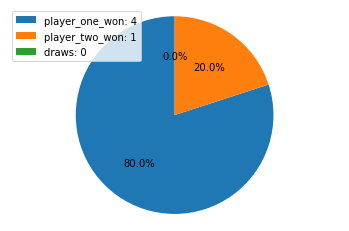

In [40]:
def draw_win_pie(data):
    # https://stackoverflow.com/questions/44076203/getting-percentages-in-legend-from-pie-matplotlib-pie-chart
    plt.pie(data.values(), autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    labels = [f'{key}: {value}' for key, value in data.items()]
    plt.legend(loc = 'best', labels=labels)
    plt.show()

draw_win_pie(get_player_win_relation(frame))


In [41]:
from datetime import datetime
import numpy as np

def avg_game_len(df):
    date_format = "%d.%m.%Y %H:%M:%S"
    date_diff = []
    for index, row in df.iterrows():
        diff = datetime.strptime(row.end_time, date_format) - datetime.strptime(row.start_time, date_format)
        date_diff.append(diff)
    df['game_len'] = date_diff
    game_len_avg = df['game_len'].mean()
    return game_len_avg

def avg_turns(df):
    return np.mean([len(x) for x in df.turns.values]) 


# based on current field, which is the most successful move?
# most succsesful starting move
avg_game_len(frame)
# avg_turns(frame)

Timedelta('0 days 00:00:02.600000')

In [3]:
import copy

def translate_player_symbols(field, symbol_one, symbol_two):
    field = copy.deepcopy(field) 
    for i in range(len(field)):
        for j in range(len(field[0])):
            if field[i][j] == symbol_one:
                field[i][j] = 0 
            elif field[i][j] == symbol_two:
                field[i][j] = 1
    return field 

def transform_turns(df):
    for index, row in df.iterrows():
        symbol_one = row['sign_player1']
        symbol_two = row['sign_player2']

        for i in range(len(row.turns)):
            row.turns[i]['state'] = translate_player_symbols(row.turns[i]['state'], symbol_one, symbol_two)
        df[index] = row
        # print(df[index])
    return df
            
abc = get_frame()
transform_turns(abc).turns[0]
        

[{'player_id': 0,
  'row': 0,
  'column': 0,
  'state': [[0, '', '', '', ''],
   ['', '', '', '', ''],
   ['', '', '', '', ''],
   ['', '', '', '', ''],
   ['', '', '', '', '']],
  'turn_number': 0,
  'latest_turn': False},
 {'player_id': 1,
  'row': 0,
  'column': 1,
  'state': [[0, 1, '', '', ''],
   ['', '', '', '', ''],
   ['', '', '', '', ''],
   ['', '', '', '', ''],
   ['', '', '', '', '']],
  'turn_number': 1,
  'latest_turn': False},
 {'player_id': 0,
  'row': 1,
  'column': 0,
  'state': [[0, 1, '', '', ''],
   [0, '', '', '', ''],
   ['', '', '', '', ''],
   ['', '', '', '', ''],
   ['', '', '', '', '']],
  'turn_number': 2,
  'latest_turn': False},
 {'player_id': 1,
  'row': 1,
  'column': 1,
  'state': [[0, 1, '', '', ''],
   [0, 1, '', '', ''],
   ['', '', '', '', ''],
   ['', '', '', '', ''],
   ['', '', '', '', '']],
  'turn_number': 3,
  'latest_turn': False},
 {'player_id': 0,
  'row': 2,
  'column': 0,
  'state': [[0, 1, '', '', ''],
   [0, 1, '', '', ''],
   [0, '',

In [4]:
def encode_field_to_string(field: list):
    return '\n'.join([' '.join([str(z) if z != "" else "-1" for z in y]) for y in field])


def decode_field_to_list(field: str):
    return [[z for z in y.split(" ")] for y in field.split('\n')]

def stat_move_recommendation(frame, field, player_num) -> tuple:
    print(field)
    moves = []  # {'current': [[]], 'next':[[]], 'won': True || False}
    for index, row in frame.iterrows():
        for i in range(len(row.turns)):
            # current field state found
            if row.turns[i]['state'] == field:
                # increment index by two to fetch the next move executed by the current player
                i = i+2
                # fetch if this game has been won by the current player
                last = row.turns[-1]
                moves.append(
                    {'current': field, 'next': row.turns[i]['state'], 'won': last['player_id'] == player_num and last['latest_turn'] == True})

    df_recom = pd.DataFrame(moves)

    # Pandas cannot group by (nested) lists so it is transformed into a string-represenatation before the groups are built
    # 0 --> player 1, 1 --> player 2, -1 --> empty cell
    df_recom['current'] = df_recom['current'].apply(encode_field_to_string)
    df_recom['next'] = df_recom['next'].apply(encode_field_to_string)

    # Output: Possible next moves by descending count of won games following this move
    groups = df_recom.groupby("next").agg(
        {'current': 'first', 'next': 'first', 'won': 'sum'}).sort_values('won', ascending=False)
    # reset the string to the nested list
    groups['current'] = groups['current'].apply(decode_field_to_list)
    groups['next'] = groups['next'].apply(decode_field_to_list)

    print(groups.current[0])
    print('------------------')
    print(groups.next[0])

    currentState = groups.current[0]
    nextState = groups.next[0]

    # find difference in current and next state to calculate row and column
    row = -1
    column = -1
    for i in range(len(currentState)):
        for j in range(len(currentState[i])):
            if currentState[i][j] != nextState[i][j]:
                row = i
                column = j
    if row == -1 or column == -1:
        raise Exception('No result')

    print(f"Recommendation --> row: {row}, column: {column}")
    return (row, column)


abc = get_frame()
abc = transform_turns(abc)
stat_move_recommendation(abc, abc.turns[0][6]['state'], 0)


[[0, 1, '', '', ''], [0, 1, '', '', ''], [0, 1, '', '', ''], [0, '', '', '', ''], ['', '', '', '', '']]
[['0', '1', '-1', '-1', '-1'], ['0', '1', '-1', '-1', '-1'], ['0', '1', '-1', '-1', '-1'], ['0', '-1', '-1', '-1', '-1'], ['-1', '-1', '-1', '-1', '-1']]
------------------
[['0', '1', '-1', '-1', '-1'], ['0', '1', '-1', '-1', '-1'], ['0', '1', '-1', '-1', '-1'], ['0', '1', '-1', '-1', '-1'], ['0', '-1', '-1', '-1', '-1']]
Recommendation --> row: 4, column: 0


(4, 0)

In [ ]:
def most_successful_first_move(field_size: int=3):
    pass